In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
import backboning_python3_networkx2_Coscia_AR as helpers # backboning https://www.michelecoscia.com/?page_id=287, altered by Alexandra
from networkx.algorithms import bipartite
import random
import matplotlib.pyplot as plt
import warnings # suppress python warnings 
warnings.filterwarnings("ignore")

In [ ]:
# imported functions (thank you Alexandra)

def visualise_graph(edge_table, node_size, labels = False, label_threshold = 6): 
    
    G = nx.from_pandas_edgelist(edge_table, "node1", "node2")
    # get degree
    %%ai get degree
    
    # layout of graph
    pos = nx.kamada_kawai_layout(G) # determine position
    
    nx.draw_networkx(G, 
                     with_labels = False, 
                     pos = pos,
                     node_size=node_size,
                     edge_color="lightgrey")
    
    if labels:
        # add labels to certain nodes
        labels = {}
        pos_select = {}
        for node in G.nodes():
            if G.degree()[node] >= label_threshold:
                #set the node name as the key and the label as its value 
                labels[node] = node
                pos_select[node] = pos[node]

        pos_higher = {}
        for k, v in pos_select.items():
            if(v[1]>0):
                pos_higher[k] = (v[0]-0.015, v[1]+0.015)
            else:
                pos_higher[k] = (v[0]-0.015, v[1]-0.015)
    
        nx.draw_networkx_labels(G,
                                labels=labels, 
                                pos = pos_higher,
                                font_size=12)
    
    plt.show()

In [3]:
%ai get degree

UsageError: Line magic function `%ai` not found.


In [ ]:
# Set the working directory
current_directory = os.getcwd()
directory = "/Users/tombombo/Documents/Oxford SNAI"
os.chdir(directory)

In [ ]:
data = pd.read_csv("output/data.csv")

In [ ]:
projects = list(set(data['project_ID']))
skills_series = data['project_skills'].str.split(" ")
flattened_skills = [skill for sublist in skills_series for skill in sublist]
skills = list(set(flattened_skills))
print(f"Number of unique skills: {len(skills)}")
print(f"Number of unique projects: {len(projects)}")

# Get the adjacency matrix, the edge table for the network in count and ratio based edge-weights


In [6]:
def build_edge_list(data):
    " I extract the edge list from the data"
    skill_project_map = {}
    # Populate the dictionary
    for index, row in data.iterrows():
        project_id = row['project_ID']
        project_skills = row['project_skills'].split()
        for skill in project_skills:
            if skill not in skill_project_map:
                skill_project_map[skill] = set()
            skill_project_map[skill].add(project_id)

    # Convert the dictionary to edge list format
    edge_list = [(skill, project_id) for skill, project_ids in skill_project_map.items() for project_id in project_ids]
    return edge_list
# Generate the edge list
# get degrees

edge_list = build_edge_list(data)
with open('edge_list.txt', 'w') as f:
    for edge in edge_list:
        f.write(f"{edge}\n")

In [ ]:
# read edge list into graph
B = nx.Graph()
B.add_nodes_from(projects, bipartite=0)
B.add_nodes_from(skills, bipartite=1)
B.add_edges_from(edge_list)

G_ratios = nx.bipartite.weighted_projected_graph(B, nodes=skills, ratio=True)
G_count = nx.bipartite.weighted_projected_graph(B, nodes=skills, ratio=False)

In [67]:
skills_adj_matrix_ratio = nx.adjacency_matrix(G_ratios)
skills_adj_matrix_count = nx.adjacency_matrix(G_count)

# Convert to DataFrame
skills_adj_matrix_ratio_table = pd.DataFrame(skills_adj_matrix_ratio.toarray(), index=G_ratios.nodes(), columns=G_ratios.nodes())
skills_adj_matrix_count_table = pd.DataFrame(skills_adj_matrix_count.toarray(), index=G_count.nodes(), columns=G_count.nodes())
 
# Save to CSV
skills_adj_matrix_ratio_table.to_csv('output/skills_adj_matrix_ratio.csv')
skills_adj_matrix_count_table.to_csv('output/skills_adj_matrix_count.csv')

In [66]:
edge_table = pd.DataFrame(G_count.edges(data=True), columns=['Source', 'Target', 'Attributes'])
edge_table = pd.concat([edge_table.drop(['Attributes'], axis=1), edge_table['Attributes'].apply(pd.Series)], axis=1)
edge_table.to_csv('output/edge_table.csv')
edge_table.head()

,Source,Target,weight
0,windows,android,24
1,windows,simulation,2
2,windows,automated-monitoring,2
3,windows,html,1
4,windows,gpo,2


# backbone the network 

In [107]:
# for simplicity I know work with a subsample of the data before applying the code to the entire dataset
# Randomly select n nodes
n = 500
# Convert nodes to a list before sampling
node_list = list(G_count.nodes())
print(len(node_list))
# Randomly select n nodes from the list
nodes = random.sample(node_list, n)

# Create the subgraph
subgraph = G_count.subgraph(nodes)
# Create the subgraph
subgraph = G_count.subgraph(nodes)

edge_table_subgraph = edge_table[
    (edge_table['Source'].isin(subgraph.nodes())) & 
    (edge_table['Target'].isin(subgraph.nodes()))
]

edge_table_subgraph.rename(columns = {'weight' : 'count' ,
                                     'Source' : 'node1',
                                     'Target' : 'node2'}, inplace = True)
edge_table_subgraph.head()
len(edge_table_subgraph)

4844


1651

Instead, taking purely the project's skills

In [ ]:
# Given the birpartite network
edge_table.rename(columns = {'weight' : 'count' ,
                                     'Source' : 'node1',
                                     'Target' : 'node2'}, inplace = True)
visualise_graph(edge_table, 
                node_size= 2, 
                labels = True,  
                label_threshold=50)

In [110]:
print("median:", edge_table_subgraph["count"].median())
edge_table_subgraph.describe()

median: 1.0


,count
count,1651.000000
mean,5.579649
std,18.896340
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,328.000000


In [130]:
edge_table_disp_filter = helpers.disparity_filter(edge_table_subgraph, undirected = True)
edge_table_disp_filter.sort_values(by = "score", ascending = True).head(5)

Calculating DF score...


,node1,node2,count,score,variance,sdev
1650,hadoop,node.js,1,0.0,0.0,0.0
1320,steinberg-cubase,ableton-live,1,0.0,0.0,0.0
1296,sap-erp,inventory-management,1,0.0,0.0,0.0
1277,data-backup,digital-forensics,1,0.0,0.0,0.0
1276,trade-law,contract-manufacturing,1,0.0,0.0,0.0


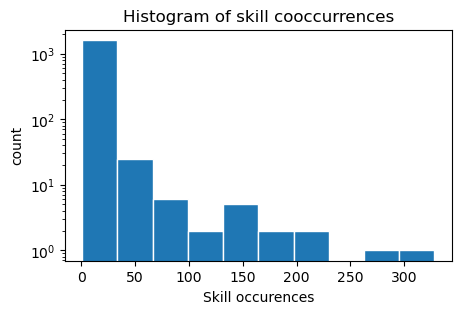

In [125]:
plt.figure(figsize = (5, 3))
plt.hist(edge_table_subgraph["count"], ec="white")
plt.yscale('log')
plt.title(f"Histogram of skill cooccurrences")
plt.xlabel('Skill occurences')
plt.ylabel('count')
plt.show()

In [135]:
edge_table_disp_filter_thresholded = helpers.thresholding(edge_table_disp_filter, 1) #7, 10
len(edge_table_disp_filter_thresholded)
edge_table_disp_filter_thresholded.sort_values(by = "score", ascending = True).head(5)

,node1,node2,count,score
297,very-small-1-9-employees,database-development,2,0.220323
296,very-small-1-9-employees,system-configuration,2,0.220323
228,very-small-1-9-employees,inbound-marketing,2,0.220323
285,very-small-1-9-employees,sales-presentations,2,0.220323
229,very-small-1-9-employees,bluetooth-feature,2,0.220323


## Compare the resulting degree distribution between unfiltered, disparity filtered, and noise-corrected graphs

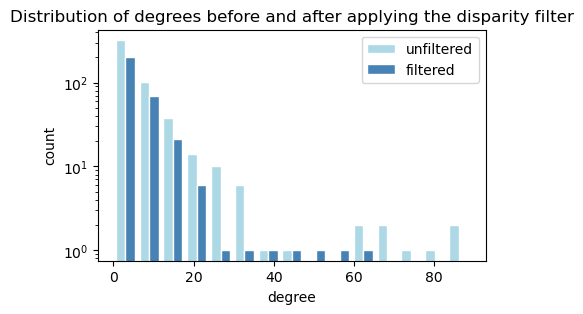

In [136]:
# check degree distribution
plt.figure(figsize = (5, 3))

# filtered graph
G_disp_filter = nx.from_pandas_edgelist(edge_table_disp_filter_thresholded, "node1", "node2", edge_attr=True)
degrees_disp_filter = list(dict(G_disp_filter.degree).values())

# original graph
G = nx.from_pandas_edgelist(edge_table_subgraph, "node1", "node2", edge_attr=True)
degrees = list(dict(subgraph.degree).values())

plt.hist([degrees, degrees_disp_filter], 
         bins = 15, 
         label=['unfiltered', 'filtered'], 
         ec="white", 
         color = ["lightblue", "steelblue"])
plt.legend(loc='upper right')
plt.yscale('log')
plt.title(f"Distribution of degrees before and after applying the disparity filter")
plt.xlabel('degree')
plt.ylabel('count')
plt.show()

In [ ]:
visualise_graph(edge_table_disp_filter_thresholded, 
                node_size= 2, 
                labels = True,  
                label_threshold=50)